In [4]:
import torch
import matplotlib.pyplot as plt

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Text(0, 0.5, 'Temperature (°Celsius)')

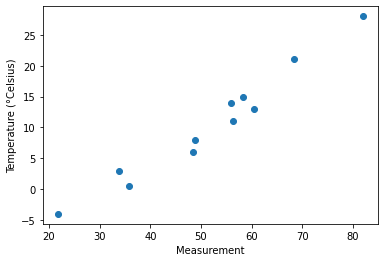

In [8]:
fig, ax = plt.subplots()
ax.scatter(t_u, t_c)
ax.set_xlabel('Measurement')
ax.set_ylabel('Temperature (°Celsius)')

In [11]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    return torch.mean((t_p - t_c)**2)

In [15]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
loss_fn(t_p, t_c)

tensor(1763.8848)

>Broadcasting, which is popular in NumPy and adapted by PyTorch, relaxes this assump- tion for most binary operations. It uses the following rules to match tensor elements:
- For each index dimension, counted from the back, if one of the operands is size 1 in that dimension, PyTorch will use the single entry along this dimen- sion with each of the entries in the other tensor along this dimension.
- If both sizes are greater than 1, they must be the same, and natural matching is used.
- If one of the tensors has more index dimensions than the other, the entirety of the other tensor will be used for each entry along these dimensions.


In [17]:
delta = 0.1
loss_w_plus  = loss_fn(model(t_u, w+delta, b), t_c)  # perturb w, calc loss
loss_w_minus = loss_fn(model(t_u, w-delta, b), t_c)  # perturb w, calc loss
dl_dw = (loss_w_plus - loss_w_minus) / (2.0 * delta)  # grad
dl_dw

tensor(4517.2974)

In [18]:
lr = 1e-2
w = w - lr * dl_dw

Use the chain rule to decompose the derivative:
$$ \frac{d\left(\text{loss function}\right)}{dw} = \frac{d\left(\text{loss function}\right)}{d t} \frac{d t}{dw} $$ 

where $t$ is the output of the model, i.e., the input to the loss function. Here we can compute it analytically:

In [23]:
def dl_dt(t_p, t_c):
    """Derivative of loss function."""
    return 2.0 * (t_p - t_c) / t_p.size(0)

def dt_dw(t_u, w, b):
    """Derivative of model wrt w."""
    return t_u

def dt_db(t_u, w, b):
    """Derivative of model wrt b."""
    return 1.0

def gradient(t_u, t_c, t_p, w, b):
    _dldt = dl_dt(t_p, t_c)
    _dldw = _dldt * dt_dw(t_u, w, b)
    _dldb = _dldt * dt_db(t_u, w, b)
    return torch.stack([
        _dldw.sum(),
        _dldb.sum(),
    ])

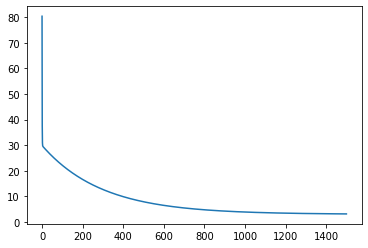

In [42]:
def train_loop(n_epochs, lr, params, t_u, t_c):
    loss_tensor = torch.zeros(n_epochs)
    for epoch in range(1, n_epochs+1):
        w, b = params

        t_p = model(t_u, w, b)  # forward pass
        loss = loss_fn(t_p, t_c)  # calculate loss
        loss_tensor[epoch-1] = loss
        grad = gradient(t_u, t_c, t_p, w, b)  # backward pass (gradient)

        # step
        params = params - lr * grad

        # print(f'Epoch {epoch:3d}: Loss {float(loss):.4f}')
    return loss_tensor, params

t_un = 0.1 * t_u

losses, params = train_loop(
    n_epochs=1500,
    lr=1e-2,
    params=torch.tensor([1.0, 0.0]),
    t_u=t_un,
    t_c=t_c,
)

fig, ax = plt.subplots()
ax.plot(losses)

Plot trained model

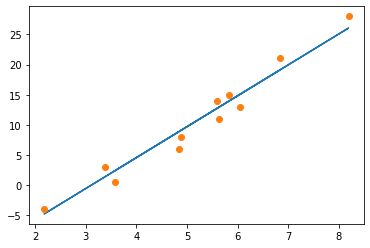

In [43]:
fig, ax = plt.subplots()
t_p = model(t_un, *params)  # unpacking

ax.plot(t_un, t_p)
ax.plot(t_un, t_c, 'o')

# `autograd`

For complicated nonlinear models, analytically computing the gradient is painstaking and a bottleneck.

PyTorch tensors can remember the operations that created and modified them; it can automatically do this differentiation by performing the chain rule behind-the-scenes.

In [51]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    return torch.mean((t_p - t_c)**2)

params = torch.tensor([1.0, 0.0], requires_grad=True)

Setting `requires_grad=True` means PyTorch will track all tensors resulting from operating on `params`. Any tensor which is has `params` as an "ancestor" will be able to see the chain of functions that created it from `params`.

For differentiable transformations, `params.grad` will automatically be populated.

In [52]:
params.grad is None

True

In [61]:
loss = loss_fn(model(t_u, *params), t_c)  # compute the loss
# loss knows it has `params` as an ancestor

loss.backward()  # computes the gradient of loss wrt params
# this is the backward pass.
# The gradients of loss wrt each ancestor is accumulated(!!!) in that 
#   ancestor's .grad attribute

The ancestors are called "leaf nodes".

`.backward()` makes gradients *accummulate* at the leaf nodes, so we need to zero them out.

In [62]:
params.grad

tensor([22586.4844,   413.0000])

Epoch 500: Loss 7.8601
Epoch 1000: Loss 3.8285
Epoch 1500: Loss 3.0922
Epoch 2000: Loss 2.9577
Epoch 2500: Loss 2.9331
Epoch 3000: Loss 2.9286
Epoch 3500: Loss 2.9278
Epoch 4000: Loss 2.9277
Epoch 4500: Loss 2.9277
Epoch 5000: Loss 2.9276


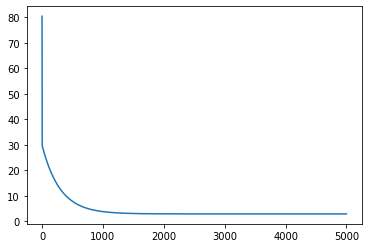

In [72]:
def training_loop(n_epochs, lr, params, t_u, t_c):
    loss_tensor = torch.zeros(n_epochs)
    for epoch in range(1, n_epochs+1):

        t_p = model(t_u, *params)  # forward pass
        loss = loss_fn(t_p, t_c)  # calculate loss
        loss_tensor[epoch-1] = loss
        
        # compute gradients
        if params.grad is not None:
            params.grad.zero_()  # zero-out the gradients
        loss.backward()

        with torch.no_grad():
            params -= lr * params.grad

        if epoch % 500 == 0:
            print(f'Epoch {epoch:3d}: Loss {float(loss):.4f}')
    return loss_tensor, params


t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_un = 0.1 * t_u

losses, params = training_loop(
    n_epochs=5000,
    lr=1e-2,
    params=torch.tensor([1.0, 0.0], requires_grad=True),
    t_u=t_un,
    t_c=t_c,
)

fig, ax = plt.subplots()
ax.plot(losses.detach());

In the future, when we register parameters with an optimizer, we will **not want to update parameters in-place!**

The `torch.optim` submodule helps us abstract away from manually updating parameters. The optimizers store a reference to the model parameters, and they can update the parameters once the gradient information is populated. Different optimization algorithms will use different update formulas.

Optimizers have two key methods:
- `.zero_grad` zeros-out the `grad` attribute of all parameters registered to it.
- `.step` updates the parameters registered to it.

In [77]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-5
optimizer = torch.optim.SGD([params], lr=lr)

In [84]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()  # compute gradients

optimizer.zero_grad()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

PyTorch provides the `torch.no_grad` context manager to shut off tracking operations for `requires_grad=True` tensors.

Another option is to `torch.detach()` the Tensor from the computation graph.

Another context manager, `toch.set_grad_enabled`, takes a `bool` as an input and runs with `autograd` accordingly enabled or disables.

This is useful, e.g., if we want to conditionally train a model or just make forward passes (predictions) with it.

In [87]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

# Exercises

5.1 Redefine the model to be $w_2 * t_u^2 + w_1 * t_u + b$.

init params: tensor([1., 0., 1.], requires_grad=True)
Epoch     5, Loss 63.47
	params: tensor([ 0.5472, -0.0737,  0.9870], requires_grad=True)
Epoch    10, Loss 13.60
	params: tensor([ 0.4286, -0.0952,  0.9826], requires_grad=True)
Epoch    15, Loss 10.14
	params: tensor([ 0.3978, -0.1030,  0.9805], requires_grad=True)
Epoch    20, Loss 9.88
	params: tensor([ 0.3901, -0.1071,  0.9790], requires_grad=True)
Epoch    25, Loss 9.85
	params: tensor([ 0.3884, -0.1103,  0.9776], requires_grad=True)
Epoch    30, Loss 9.83
	params: tensor([ 0.3883, -0.1133,  0.9763], requires_grad=True)


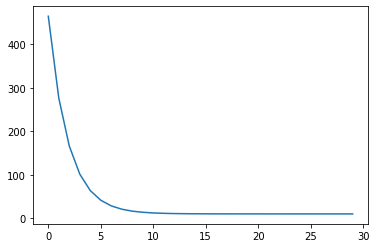

In [117]:
# t_u - model inputs
# t_p - model predictions
# t_c - ground truth targets
# w2, w1, b - model parameters
def model(t_u, w2, w1, b):
    """Map inputs to predictions."""
    return w2 * torch.pow(t_u, 2) + w1 * t_u + b

def loss_fn(t_p, t_c):
    """Map """
    return torch.mean((t_p - t_c)**2)

def training_loop(t_u, t_c, params, optimizer, n_epochs: int = 10):    
    losses = torch.zeros(n_epochs)
    print(f'init params: {params}')
    for epoch in range(1, n_epochs+1):
        t_p = model(t_u, *params)  # forward pass
        train_loss = loss_fn(t_p, t_c)
        losses[epoch-1] = train_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f"Epoch {epoch:5d}, Loss {train_loss:.2f}")
            print(f"\tparams: {params}")
    return params.detach(), losses.detach()

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_un = 0.1 * t_u

lr = 1e-4
params = torch.tensor([1.0, 0.0, 1.0], requires_grad=True)  # device?
optimizer = torch.optim.SGD([params], lr=lr)

params, losses = training_loop(
    t_u=t_un,
    t_c=t_c,
    optimizer=optimizer,
    params=params,
    n_epochs=30,
    )

fig, ax = plt.subplots()
ax.plot(losses);


a. What parts of the training loop, and so on, need to change to accommodate this redefinition?

Only the model definition needed changed. Other things do change, but behind-the-scenes; e.g., `params` is now a 3-vector (`torch.Tensor`).

b. What parts are agnostic to swapping out the model?

The actual calls to the `torch.optim` object.

c. Is the resulting loss higher or lower after training?

I didn't directly compare, but most likely lower due to the higher model complexity.

d. Is the actual result better or worse?

The actual result may be worse if the model is overfitting.

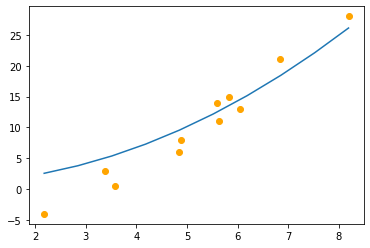

In [133]:
fig, ax = plt.subplots()
ax.scatter(t_un, t_c, c='orange')

t_plot = torch.linspace(start=t_un.min(), end=t_un.max(), steps=10)
ax.plot(t_plot, model(t_plot, *params))